# Отчёт: Однослойный и многослойный перцептрон

**Цель работы:** Освоить реализацию и обучение однослойного перцептрона на Python, исследовать его поведение на линейно разделимых и нелинейно разделимых данных. Освоить основы построения многослойных сетей.

**Студент по итогам должен уметь:**
- записывать формулу перцептрона и правило обучения;
- реализовывать обучение «с нуля» на Python, без sklearn;
- визуализировать разделяющую прямую и интерпретировать веса;
- объяснять ограничение линейной разделимости (на примере XOR);
- реализовывать многослойный перцептрон на Python;
- знать метод обратного распространения ошибки.

## 1. Краткое изложение теории

### 1.1. Модель перцептрона

**Однослойный перцептрон** — это линейный классификатор. Выход вычисляется по формуле:

$$y = f\left(\sum_{i=1}^{n} w_i x_i + b\right) = f(\mathbf{w}^T \mathbf{x} + b)$$

где:
- $\mathbf{x} = (x_1, \ldots, x_n)$ — входной вектор;
- $\mathbf{w} = (w_1, \ldots, w_n)$ — веса;
- $b$ — смещение (bias);
- $f$ — функция активации (обычно ступенчатая: $f(z) = 1$ при $z \geq 0$, иначе $0$).

### 1.2. Правило обучения (правило Розенблатта)

Для каждого обучающего примера $(\mathbf{x}, t)$ (где $t$ — целевой выход):

1. Вычислить выход: $y = f(\mathbf{w}^T \mathbf{x} + b)$
2. Ошибка: $e = t - y$
3. Обновить веса: $w_i \leftarrow w_i + \eta \cdot e \cdot x_i$
4. Обновить смещение: $b \leftarrow b + \eta \cdot e$

где $\eta$ — скорость обучения (learning rate).

### 1.3. Линейная разделимость

Перцептрон строит **гиперплоскость** (в 2D — прямую), разделяющую классы. Он может обучиться **только** на **линейно разделимых** данных: когда существует такая прямая (гиперплоскость), что все точки одного класса лежат по одну сторону, а другого — по другую.

**Пример XOR:** Функция XOR нелинейно разделима. Точки (0,0) и (1,1) дают 0, а (0,1) и (1,0) — 1. Невозможно провести одну прямую, разделяющую эти два класса. Поэтому однослойный перцептрон **не может** обучиться XOR.

### 1.4. Многослойный перцептрон (MLP)

**MLP** состоит из нескольких слоёв нейронов. Между входами и выходами есть **скрытые слои**. Каждый нейрон применяет нелинейную функцию активации (сигмоида, ReLU и т.д.). Благодаря скрытым слоям MLP может аппроксимировать **нелинейные** границы решений.

### 1.5. Метод обратного распространения ошибки (Backpropagation)

Для обучения MLP используется **градиентный спуск** по функции потерь. **Backpropagation** — алгоритм эффективного вычисления градиентов:

1. **Прямой проход:** вычисляем выходы всех слоёв от входа к выходу.
2. **Обратный проход:** вычисляем градиенты по цепному правилу, распространяя ошибку от выхода к входам.
3. Обновляем веса: $w \leftarrow w - \eta \cdot \frac{\partial L}{\partial w}$.

## 2. Код класса Perceptron с комментариями

In [1]:
import numpy as np


class Perceptron:
    """
    Однослойный перцептрон. Обучение без sklearn, по правилу Розенблатта.
    """

    def __init__(self, learning_rate=0.1, n_iter=100):
        """
        learning_rate: шаг обновления весов (η)
        n_iter: число эпох обучения
        """
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weights = None  # веса w
        self.bias = None    # смещение b

    def _activation(self, z):
        """Ступенчатая функция активации: 1 если z >= 0, иначе 0."""
        return (z >= 0).astype(int)

    def fit(self, X, y):
        """
        Обучение перцептрона по правилу Розенблатта.
        X: массив (n_samples, n_features)
        y: массив (n_samples,) с метками 0 или 1
        """
        n_samples, n_features = X.shape
        # Инициализация: веса и смещение нулевые
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for _ in range(self.n_iter):
            for i in range(n_samples):
                # Прямой проход: y = f(w^T x + b)
                z = np.dot(self.weights, X[i]) + self.bias
                pred = self._activation(np.array([z]))[0]

                # Ошибка: e = t - y
                error = y[i] - pred

                # Правило Розенблатта: w += η * e * x, b += η * e
                self.weights += self.lr * error * X[i]
                self.bias += self.lr * error

        return self

    def predict(self, X):
        """Предсказание для набора примеров."""
        z = np.dot(X, self.weights) + self.bias
        return self._activation(z)

    def get_decision_boundary(self, x_range):
        """
        Для 2D: возвращает x2 как функцию x1 для разделяющей прямой.
        Прямая: w1*x1 + w2*x2 + b = 0  =>  x2 = -(w1*x1 + b) / w2
        """
        w1, w2 = self.weights[0], self.weights[1]
        if abs(w2) < 1e-10:
            return None  # вертикальная прямая или вырождение
        return -(w1 * x_range + self.bias) / w2

## 3. Таблицы истинности и предсказания для AND, OR

In [2]:
# Данные для логических функций (добавляем единицу для bias в X или используем отдельный bias)
# AND: (0,0)->0, (0,1)->0, (1,0)->0, (1,1)->1
# OR:  (0,0)->0, (0,1)->1, (1,0)->1, (1,1)->1

X_and = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_and = np.array([0, 0, 0, 1])

X_or = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_or = np.array([0, 1, 1, 1])

# Обучение перцептронов
perceptron_and = Perceptron(learning_rate=0.1, n_iter=100)
perceptron_and.fit(X_and, y_and)

perceptron_or = Perceptron(learning_rate=0.1, n_iter=100)
perceptron_or.fit(X_or, y_or)

# Предсказания
pred_and = perceptron_and.predict(X_and)
pred_or = perceptron_or.predict(X_or)

In [12]:
print('=' * 50)
print('AND: Таблица истинности и предсказания')
print('=' * 50)
print(f"{'x1':<4} {'x2':<4} {'Истина':<8} {'Предсказание':<12}")
print('-' * 50)
for i in range(4):
    print(f"{X_and[i,0]:<4} {X_and[i,1]:<4} {y_and[i]:<8} {pred_and[i]:<12}")
print()
print('=' * 50)
print('OR: Таблица истинности и предсказания')
print('=' * 50)
print(f"{'x1':<4} {'x2':<4} {'Истина':<8} {'Предсказание':<12}")
print('-' * 50)
for i in range(4):
    print(f"{X_or[i,0]:<4} {X_or[i,1]:<4} {y_or[i]:<8} {pred_or[i]:<12}")

AND: Таблица истинности и предсказания
x1   x2   Истина   Предсказание
--------------------------------------------------
0    0    0        0           
0    1    0        0           
1    0    0        0           
1    1    1        1           

OR: Таблица истинности и предсказания
x1   x2   Истина   Предсказание
--------------------------------------------------
0    0    0        0           
0    1    1        1           
1    0    1        1           
1    1    1        1           


## 4. График разделяющей прямой (на примере AND)

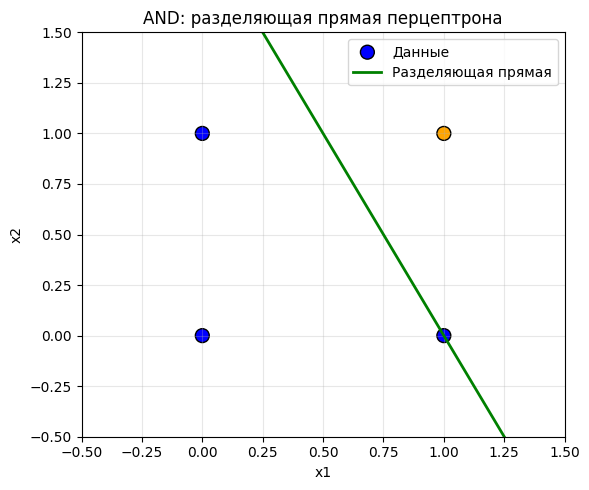

Веса: w1=0.200, w2=0.100
Смещение: b=-0.200
Уравнение прямой: w1*x1 + w2*x2 + b = 0


In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))

# Точки AND: класс 0 — синие, класс 1 — оранжевые
colors = ['blue' if y == 0 else 'orange' for y in y_and]
ax.scatter(X_and[:, 0], X_and[:, 1], c=colors, s=100, edgecolors='black', label='Данные')

# Разделяющая прямая: w1*x1 + w2*x2 + b = 0
x_range = np.linspace(-0.5, 1.5, 100)
x2_line = perceptron_and.get_decision_boundary(x_range)
if x2_line is not None:
    ax.plot(x_range, x2_line, 'g-', linewidth=2, label='Разделяющая прямая')

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('AND: разделяющая прямая перцептрона')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Веса: w1={perceptron_and.weights[0]:.3f}, w2={perceptron_and.weights[1]:.3f}')
print(f'Смещение: b={perceptron_and.bias:.3f}')
print('Уравнение прямой: w1*x1 + w2*x2 + b = 0')

## 5. Эксперимент с XOR и объяснение провала

In [15]:
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([0, 1, 1, 0])

perceptron_xor = Perceptron(learning_rate=0.1, n_iter=500)
perceptron_xor.fit(X_xor, y_xor)

pred_xor = perceptron_xor.predict(X_xor)

print('XOR: Таблица истинности и предсказания')
print('=' * 50)
print(f"{'x1':<4} {'x2':<4} {'Истина':<8} {'Предсказание':<12}")
print('-' * 50)
for i in range(4):
    print(f"{X_xor[i,0]:<4} {X_xor[i,1]:<4} {y_xor[i]:<8} {pred_xor[i]:<12}")
print()
print('Точность:', np.mean(pred_xor == y_xor) * 100, '%')

XOR: Таблица истинности и предсказания
x1   x2   Истина   Предсказание
--------------------------------------------------
0    0    0        1           
0    1    1        1           
1    0    1        0           
1    1    0        0           

Точность: 50.0 %


/var/folders/pf/0p44d6cs14ddfqyjh5b5rhs80000gn/T/ipykernel_33923/4227751646.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


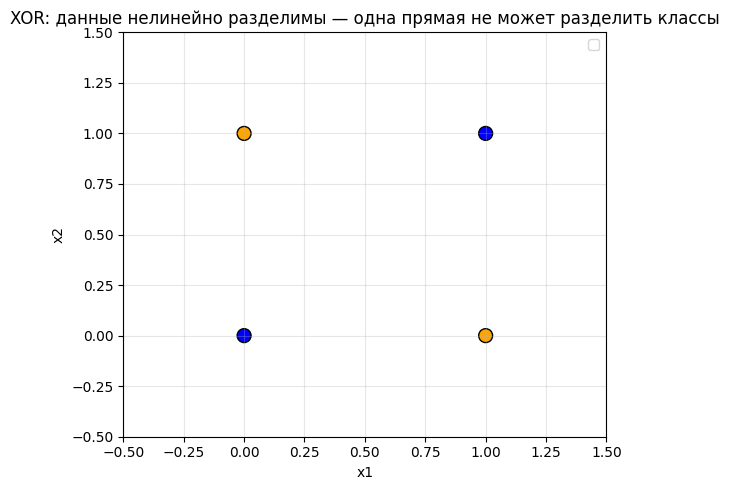

In [16]:
# Визуализация: почему XOR не работает
fig, ax = plt.subplots(figsize=(6, 5))

colors = ['blue' if y == 0 else 'orange' for y in y_xor]
ax.scatter(X_xor[:, 0], X_xor[:, 1], c=colors, s=100, edgecolors='black')

# Любая прямая не может разделить классы
x_range = np.linspace(-0.5, 1.5, 100)
x2_line = perceptron_xor.get_decision_boundary(x_range)
if x2_line is not None:
    ax.plot(x_range, x2_line, 'g--', linewidth=2, alpha=0.7, label='Попытка разделения')

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('XOR: данные нелинейно разделимы — одна прямая не может разделить классы')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Объяснение провала XOR:** Точки (0,0) и (1,1) относятся к классу 0, а (0,1) и (1,0) — к классу 1. Они расположены «крестом»: класс 0 по диагонали, класс 1 по другой диагонали. Любая прямая делит плоскость на две полуплоскости, поэтому невозможно одной прямой отделить одну диагональ от другой. XOR **нелинейно разделим** — требуется нелинейная граница (например, две прямые или кривая).

## 6. Вывод: возможности и ограничения однослойного перцептрона

**Возможности:**
- Обучение на линейно разделимых данных (AND, OR, линейная классификация).
- Простота реализации и интерпретации весов.
- Разделяющая гиперплоскость: веса задают её ориентацию, смещение — сдвиг.

**Ограничения:**
- **Не может** обучиться на нелинейно разделимых данных (XOR и подобные).
- Только одна гиперплоскость — не подходит для сложных границ решений.
- Для решения XOR и других нелинейных задач нужен **многослойный перцептрон**.

## 7. Код класса MLPerceptron с комментариями

In [17]:
class MLPerceptron:
    """
    Многослойный перцептрон с одним скрытым слоем.
    Обучение методом обратного распространения ошибки (backpropagation).
    Без sklearn.
    """

    def __init__(self, hidden_size=4, learning_rate=0.5, n_iter=5000):
        """
        hidden_size: число нейронов в скрытом слое
        learning_rate: скорость обучения
        n_iter: число эпох
        """
        self.hidden_size = hidden_size
        self.lr = learning_rate
        self.n_iter = n_iter
        self.W1 = None  # веса вход -> скрытый слой
        self.b1 = None  # смещения скрытого слоя
        self.W2 = None  # веса скрытый -> выход
        self.b2 = None  # смещение выхода

    def _sigmoid(self, z):
        """Сигмоида: σ(z) = 1/(1+e^(-z)). Ограничиваем для численной стабильности."""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        """Производная сигмоиды: σ'(z) = σ(z)*(1-σ(z))."""
        s = self._sigmoid(z)
        return s * (1 - s)

    def fit(self, X, y):
        """
        Обучение методом обратного распространения ошибки.
        X: (n_samples, n_features), y: (n_samples,) — метки 0 или 1
        """
        n_samples, n_features = X.shape
        h = self.hidden_size

        # Инициализация весов (Xavier-like)
        self.W1 = np.random.randn(n_features, h) * 0.5
        self.b1 = np.zeros(h)
        self.W2 = np.random.randn(h, 1) * 0.5
        self.b2 = np.zeros(1)

        y = y.reshape(-1, 1)  # (n, 1) для совместимости

        for _ in range(self.n_iter):
            # === Прямой проход ===
            z1 = X @ self.W1 + self.b1      # вход скрытого слоя
            a1 = self._sigmoid(z1)          # выход скрытого слоя
            z2 = a1 @ self.W2 + self.b2     # вход выходного слоя
            a2 = self._sigmoid(z2)          # выход (предсказание)

            # === Обратный проход (backpropagation) ===
            # Ошибка на выходе: dL/da2 для MSE: (a2 - y)
            # Для бинарной классификации с сигмоидой: delta2 = (a2 - y) * sigmoid'(z2)
            delta2 = (a2 - y) * self._sigmoid_derivative(z2)

            # Градиент по W2 и b2
            dW2 = a1.T @ delta2
            db2 = np.sum(delta2, axis=0)

            # Ошибка на скрытом слое: распространяем назад
            delta1 = (delta2 @ self.W2.T) * self._sigmoid_derivative(z1)

            # Градиент по W1 и b1
            dW1 = X.T @ delta1
            db1 = np.sum(delta1, axis=0)

            # Обновление весов (градиентный спуск)
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1

        return self

    def predict(self, X):
        """Предсказание: округляем выход сигмоиды до 0 или 1."""
        z1 = X @ self.W1 + self.b1
        a1 = self._sigmoid(z1)
        z2 = a1 @ self.W2 + self.b2
        a2 = self._sigmoid(z2)
        return (a2 >= 0.5).astype(int).flatten()

## 8. Результаты эксперимента с XOR (многослойный перцептрон) и выводы

In [18]:
np.random.seed(42)
mlp_xor = MLPerceptron(hidden_size=4, learning_rate=0.5, n_iter=10000)
mlp_xor.fit(X_xor, y_xor)

pred_mlp_xor = mlp_xor.predict(X_xor)

print('XOR с многослойным перцептроном')
print('=' * 50)
print(f"{'x1':<4} {'x2':<4} {'Истина':<8} {'Предсказание':<12}")
print('-' * 50)
for i in range(4):
    print(f'{X_xor[i,0]:<4} {X_xor[i,1]:<4} {y_xor[i]:<8} {pred_mlp_xor[i]:<12}')
print()
print('Точность:', np.mean(pred_mlp_xor == y_xor) * 100, '%')

XOR с многослойным перцептроном
x1   x2   Истина   Предсказание
--------------------------------------------------
0    0    0        0           
0    1    1        1           
1    0    1        1           
1    1    0        0           

Точность: 100.0 %


/var/folders/pf/0p44d6cs14ddfqyjh5b5rhs80000gn/T/ipykernel_33923/3066092253.py:81: RuntimeWarning: divide by zero encountered in matmul
  z1 = X @ self.W1 + self.b1
/var/folders/pf/0p44d6cs14ddfqyjh5b5rhs80000gn/T/ipykernel_33923/3066092253.py:81: RuntimeWarning: overflow encountered in matmul
  z1 = X @ self.W1 + self.b1
/var/folders/pf/0p44d6cs14ddfqyjh5b5rhs80000gn/T/ipykernel_33923/3066092253.py:81: RuntimeWarning: invalid value encountered in matmul
  z1 = X @ self.W1 + self.b1
/var/folders/pf/0p44d6cs14ddfqyjh5b5rhs80000gn/T/ipykernel_33923/3066092253.py:83: RuntimeWarning: divide by zero encountered in matmul
  z2 = a1 @ self.W2 + self.b2
/var/folders/pf/0p44d6cs14ddfqyjh5b5rhs80000gn/T/ipykernel_33923/3066092253.py:83: RuntimeWarning: overflow encountered in matmul
  z2 = a1 @ self.W2 + self.b2
/var/folders/pf/0p44d6cs14ddfqyjh5b5rhs80000gn/T/ipykernel_33923/3066092253.py:83: RuntimeWarning: invalid value encountered in matmul
  z2 = a1 @ self.W2 + self.b2


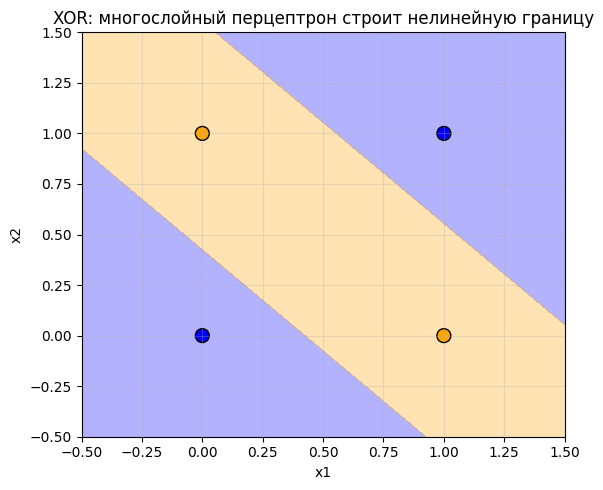

In [19]:
# Визуализация границы решений MLP (сетка)
xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 100), np.linspace(-0.5, 1.5, 100))
Z = mlp_xor.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(6, 5))
ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.5, 0.5, 1.5], colors=['blue', 'orange'])
colors = ['blue' if y == 0 else 'orange' for y in y_xor]
ax.scatter(X_xor[:, 0], X_xor[:, 1], c=colors, s=100, edgecolors='black')
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('XOR: многослойный перцептрон строит нелинейную границу')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Выводы:**

1. **Многослойный перцептрон** с одним скрытым слоем и **нелинейной активацией** (сигмоида) успешно решает задачу XOR.
2. Скрытый слой позволяет строить **нелинейные** границы решений: комбинация нескольких «полуплоскостей» даёт сложные области.
3. **Метод обратного распространения ошибки** позволяет эффективно вычислять градиенты и обучать веса всех слоёв.
4. Для XOR достаточно скрытого слоя из 2–4 нейронов; архитектура MLP преодолевает ограничение линейной разделимости однослойного перцептрона.